## CMPN403 Programming Assignment
Team:
- Yomna Osama Hussien 1190203
- Mohamed Hassan Mohamed 1190118

In [2]:
import re
import json
import graphviz
from typing import *
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Utility functions

In [3]:
def verify_regex(regex: str) -> bool:
    try:
        re.compile(regex)
        return True
    except re.error:
        return False
    
def get_subregex(regex: str, i: int) -> str:
        depth = 1
        subregex = regex[i+1:]
        for j in range(len(subregex)):
            if subregex[j] == '(':
                depth += 1
            elif subregex[j] == ')':
                depth -= 1
            if depth == 0:
                subregex = subregex[:j]
                break
        return subregex

def json_write(states: Dict[str, Dict], filename: str) -> None:
    if not filename.endswith('.json'):
        filename += '.json'
        
    with open(filename, 'w') as file:
        json.dump(states, file, indent=4)

def draw_FSM(json_file: str, label: str) -> graphviz.Digraph:
    with open(json_file, 'r') as file:
        fsm: Dict[str, Dict] = json.load(file)

    dot = graphviz.Digraph(comment=label)

    dot.node('startingStateH', 'startingStateH', style='invis')
    
    # add nodes
    for key in fsm.keys():
        if key == 'startingState':
            continue
        if fsm[key]['isTerminatingState']:
            dot.node(key, key, shape='doublecircle')
        else:
            dot.node(key, key)
    
    # add edges
    for key in fsm.keys():
        if key == 'startingState':
            continue
        for symbol in fsm[key].keys():
            if symbol == 'isTerminatingState':
                continue
            if label == 'NFA':
                for next_state in fsm[key][symbol]:
                    if symbol == 'epsilon':
                        symbol = 'ε'
                    dot.edge(key, next_state, label=symbol)
            else:
                next_state = fsm[key][symbol]
                dot.edge(key, next_state, label=symbol)
    
    dot.edge('startingStateH', fsm['startingState'])

    return dot

def draw_dfa(json_file_path: str) -> graphviz.Digraph:
    with open(json_file_path, 'r') as file:
        dfa_states: Dict[str, Dict] = json.load(file)

    dot = graphviz.Digraph(comment='DFA')

    # Add invisible starting state
    dot.node('startingStateH', 'startingStateH', style='invis')
    
    # Add nodes
    for state_name in dfa_states.keys():
        if state_name == 'startingState':
            continue
        if dfa_states[state_name]['isTerminatingState']:
            dot.node(state_name, state_name, shape='doublecircle')
        else:
            dot.node(state_name, state_name)
    
    # Add edges
    for state_name in dfa_states.keys():
        if state_name == 'startingState':
            continue
        for symbol in dfa_states[state_name].keys():
            if symbol == 'isTerminatingState':
                continue
            next_state = dfa_states[state_name][symbol]
            label = symbol if symbol != 'epsilon' else 'ε'
            dot.edge(state_name, next_state, label=label)
    
    dot.edge('startingStateH', dfa_states['startingState'])

    return dot

def display_and_save_image_DFA(json_file: str, fileName: str) -> None:
    dot = draw_dfa(json_file)
    dot.format = 'png'
    dot.render(fileName)
    
    img = mpimg.imread(fileName+'.png')
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.figure(figsize=(15, 15))
    plt.show()


def display_and_save_image(json_file: str, fileName: str, label: str) -> None:
    dot = draw_FSM(json_file, label)
    dot.format = 'png'
    dot.render(fileName)
    
    img = mpimg.imread(fileName+'.png')
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.figure(figsize=(15, 15))
    plt.show()

### Regex to NFA

In [4]:
class NFA:
    def __init__(self) -> None:
        self.start_state = 0
        self.next_state = 0
        self.prev_state = 0
        self.prev_start = 0
        self.states = {"startingState": "S0", "S0": {"isTerminatingState": False}}

    def generate_NFA(self, regex: str, filename: str) -> None:
        if not verify_regex(regex):
            print("Invalid regex")
            return

        i = self.build_NFA(regex)
        
        if i == len(regex):
            self.states["S" + str(self.next_state)]["isTerminatingState"] = True
            self.states.update({"startingState": ("S" + str(self.prev_start))})

        json_write(self.states, filename)
    
    def build_NFA(self, regex: str) -> int:
        i = 0
        while i < len(regex):
            if regex[i] == '(':
                subregex = get_subregex(regex, i)

                start_state = self.start_state
                next_state = self.next_state
                prev_state = self.prev_state
                prev_start = self.prev_start

                sub_value = self.next_state + 1
                self.start_state = sub_value
                self.next_state = sub_value
                self.prev_state = sub_value
                self.prev_start = sub_value

                self.states.update({"S" + str(self.next_state): {"isTerminatingState": False}})
                self.build_NFA(subregex)

                if "ε" in self.states["S" + str(next_state)].keys():
                    self.states["S" + str(next_state)]["ε"].append("S" + str(self.prev_start))
                else:
                    self.states["S" + str(next_state)]["ε"] = ["S" + str(self.prev_start)]

                self.prev_state = self.prev_start
                self.prev_start = prev_start
                self.start_state = self.next_state

                i += len(subregex) + 2
                
            elif regex[i] == '|':
                i += 1

                self.states.update({"S" + str(self.next_state + 1): {"isTerminatingState": False}})

                start_state = self.start_state
                next_state = self.next_state
                prev_state = self.prev_state
                prev_start = self.prev_start

                alt_value = self.next_state + 1
                self.start_state = alt_value
                self.next_state = alt_value
                self.prev_state = alt_value
                self.prev_start = alt_value
                
                self.build_NFA(regex[i:])

                alt_start_state = self.start_state
                alt_next_state = self.next_state
                alt_prev_state = self.prev_state
                alt_prev_start = self.prev_start

                self.start_state = start_state
                self.next_state = next_state
                self.prev_state = prev_state
                self.prev_start = prev_start

                i += len(regex[i:])

                self.states.update({"S" + str(alt_next_state + 1): {"isTerminatingState": False}})
                
                if 'ε' in self.states["S" + str(alt_next_state + 1)].keys():
                    self.states["S" + str(alt_next_state + 1)]["ε"].append("S" + str(self.prev_start))
                    self.states["S" + str(alt_next_state + 1)]["ε"].append("S" + str(alt_prev_start))
                else:
                    self.states["S" + str(alt_next_state + 1)]["ε"] = ["S" + str(self.prev_start), "S" + str(alt_prev_start)]

                self.states.update({"S" + str(alt_next_state + 2): {"isTerminatingState": False}}) 

                if 'ε' in self.states["S" + str(alt_next_state)].keys():
                    self.states["S" + str(alt_next_state)]["ε"].append("S" + str(alt_next_state + 2))
                else:
                   self.states["S" + str(alt_next_state)]["ε"] = ["S" + str(alt_next_state + 2)]

                if 'ε' in self.states["S" + str(self.next_state)].keys():
                    self.states["S" + str(self.next_state)]["ε"].append("S" + str(alt_next_state + 2))
                else:
                    self.states["S" + str(self.next_state)]["ε"] = ["S" + str(alt_next_state + 2)] 

                self.prev_start = alt_next_state + 1
                self.next_state = alt_next_state + 2
                self.prev_state = alt_next_state + 1
                self.start_state = alt_next_state
            elif regex[i] == '[':
                substring, end = self.get_range_substring(regex, i)
                self.start_state, self.next_state, self.prev_state, self.states = self.add_state(substring, self.start_state, self.next_state, self.prev_state, self.states, i, True)
                i = end 

            else:
                self.start_state, self.next_state, self.prev_state, self.states = self.add_state(regex, self.start_state, self.next_state, self.prev_state, self.states, i)
                i += 1
        return i
    
    def add_state(self, regex: str, start_state: int, next_state: int,prev_state: int, states: Dict[str, Dict], i: int, isRange: bool = False) -> Tuple[int, int, Dict[str, Dict]]:
        next_state += 1
        if isRange:
            return self.handleRange(start_state, next_state, prev_state, states, regex)
        
        if(regex[i] == '+'):
            return self.handlePositiveClosure(start_state, next_state, prev_state, states)
        
        if regex[i] == '*':
            return self.handleZeroOrMore(start_state, next_state, prev_state, states)
        
        if regex[i] == '?':
           return self.handleZeroOrOne(start_state, next_state, prev_state, states)
        
        if regex[i] in states["S" + str(start_state)]:
            states["S" + str(start_state)][regex[i]].append("S" + str(next_state))
        else:
            states["S" + str(start_state)][regex[i]] = ["S" + str(next_state)]
        
        states["S" + str(next_state)] = {"isTerminatingState": False}
        prev_state = start_state
        start_state = next_state

        return start_state, next_state, prev_state, states

    def get_range_substring(self, regex: str, i: int) -> Tuple[str, int]:
        subString = ""
        end = i
        regex = regex[i:]       # discard part before bracket (but takes the bracket itself)
        for j in range(len(regex)):
            if regex[j] == ']':             # matching first closed bracket
                subString = regex[:j+1]       # discard part after bracket (but takes the bracket itself)
                end = i+j+1
                return subString, end
        
        return subString, end

    def handleRange(self, start_state: int, next_state: int, prev_state: int, states: Dict[str, Dict], substring: str) -> Tuple[int, int,int, Dict[str, Dict]]:
        if substring in states["S" + str(start_state)].keys():
            states["S" + str(start_state)][substring].append("S" + str(next_state))
        else:
            states["S" + str(start_state)][substring] = ["S" + str(next_state)]
        
        states["S" + str(next_state)] = {"isTerminatingState": False}
        prev_state = start_state
        start_state = next_state

        return start_state, next_state, prev_state, states

    def handlePositiveClosure(self, start_state: int, next_state: int, prev_state: int, states: Dict[str, Dict]) -> Tuple[int, int,int, Dict[str, Dict]]:
        states["S" + str(next_state)] = {"isTerminatingState": False}  
        if 'ε' in states["S" + str(start_state)]:
            states["S" + str(start_state)]["ε"].append("S" + str(prev_state))
            states["S" + str(start_state)]["ε"].append("S" + str(next_state))
        else:
            states["S" + str(start_state)]["ε"] = ["S" + str(prev_state), "S" + str(next_state)]
        prev_state = start_state
        start_state = next_state
        return start_state, next_state, prev_state, states
    
    def handleZeroOrMore(self, start_state: int, next_state: int, prev_state: int, states: Dict[str, Dict]) -> Tuple[int, int,int, Dict[str, Dict]]:
        states["S" + str(next_state)] = {"isTerminatingState": False}  
        if 'ε' in states["S" + str(start_state)]:
            states["S" + str(start_state)]["ε"].append("S" + str(prev_state))
            states["S" + str(start_state)]["ε"].append("S" + str(next_state))
        else:
            states["S" + str(start_state)]["ε"] = ["S" + str(prev_state), "S" + str(next_state)]
        
        if 'ε' in states["S" + str(prev_state)]:
            states["S" + str(prev_state)]["ε"].append("S" + str(next_state))
        else:
            states["S" + str(prev_state)]["ε"] = ["S" + str(next_state)]
            
        prev_state = start_state
        start_state = next_state
        return start_state, next_state, prev_state, states
    
    def handleZeroOrOne(self, start_state: int, next_state: int, prev_state: int, states: Dict[str, Dict]) -> Tuple[int, int,int, Dict[str, Dict]]:
        states["S" + str(next_state)] = {"isTerminatingState": False}  
        if 'ε' in states["S" + str(start_state)]:
            states["S" + str(start_state)]["ε"].append("S" + str(next_state))
        else:
            states["S" + str(start_state)]["ε"] = ["S" + str(next_state)]
        
        if 'ε' in states["S" + str(prev_state)]:
            states["S" + str(prev_state)]["ε"].append("S" + str(next_state))
        else:
            states["S" + str(prev_state)]["ε"] = ["S" + str(next_state)]
        
        prev_state = start_state
        start_state = next_state
        return start_state, next_state, prev_state, states

#### Functional Testing

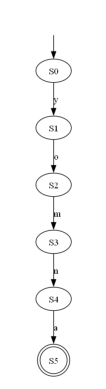

<Figure size 1500x1500 with 0 Axes>

In [5]:
nfa = NFA()
nfa.generate_NFA("yomna", "literal.json")
display_and_save_image("literal.json", "literal", "NFA")

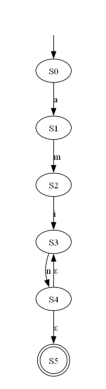

<Figure size 1500x1500 with 0 Axes>

In [6]:
nfa = NFA()
nfa.generate_NFA("amin+", "positiveClosure.json")
display_and_save_image("positiveClosure.json", "positiveClosure", "NFA")

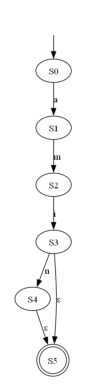

<Figure size 1500x1500 with 0 Axes>

In [6]:
nfa = NFA()
nfa.generate_NFA("amin?", "zeroOrOne.json")
display_and_save_image("zeroOrOne.json", "zeroOrOne", "NFA")

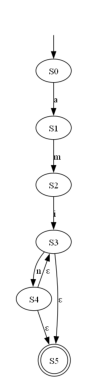

<Figure size 1500x1500 with 0 Axes>

In [7]:
nfa = NFA()
nfa.generate_NFA("amin*", "zeroOrMore.json")
display_and_save_image("zeroOrMore.json", "zeroOrMore", "NFA")

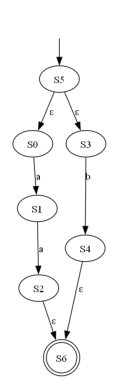

<Figure size 1500x1500 with 0 Axes>

In [8]:
nfa = NFA()
nfa.generate_NFA("aa|b", "Alternate.json")
display_and_save_image("Alternate.json", "Alternate", "NFA")

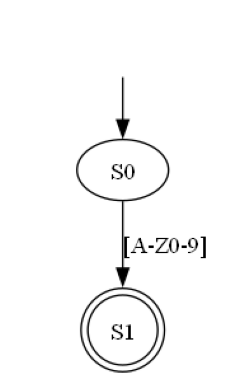

<Figure size 1500x1500 with 0 Axes>

In [9]:
nfa = NFA()
nfa.generate_NFA("[A-Z0-9]", "range.json")
display_and_save_image("range.json", "range", "NFA")

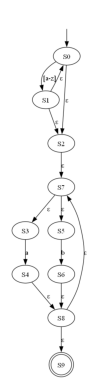

<Figure size 1500x1500 with 0 Axes>

In [10]:
nfa = NFA()
nfa.generate_NFA("[a-z]*(a|b)+", "brackets.json")
display_and_save_image("brackets.json", "brackets", "NFA")

#### NFA Testing

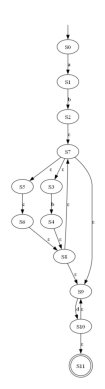

<Figure size 1500x1500 with 0 Axes>

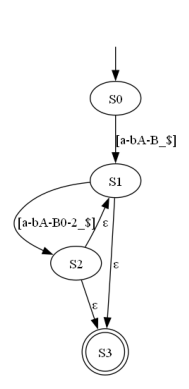

<Figure size 1500x1500 with 0 Axes>

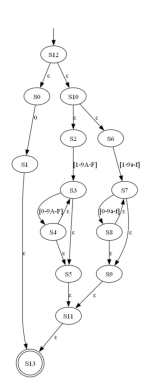

<Figure size 1500x1500 with 0 Axes>

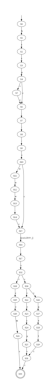

<Figure size 1500x1500 with 0 Axes>

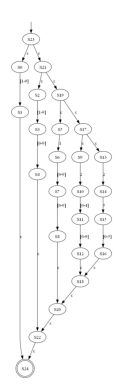

<Figure size 1500x1500 with 0 Axes>

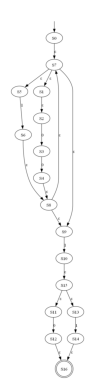

<Figure size 1500x1500 with 0 Axes>

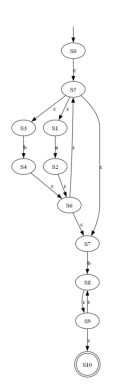

<Figure size 1500x1500 with 0 Axes>

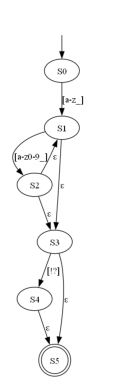

<Figure size 1500x1500 with 0 Axes>

In [11]:
# Testcases
test1 = "ab(b|c)*d+"
test2 = "[a-bA-B_$][a-bA-B0-2_$]*"
test3 = "0|[1-9A-F][0-9A-F]*|[1-9a-f][0-9a-f]*"
test4 = "https?://(www.)?[a-zA-Z0-9-_].(com|org|net)"
test5 = "[1-9]|[1-9][0-9]|1[0-9][0-9]|2[0-4][0-9]|25[0-5]"
test6 = "((00)|1)*1(0|1)"
test7 = "(a|b)*bc+"
test8 = "[a-z_][a-z0-9_]*[!?]?"

nfa = NFA()
nfa.generate_NFA(test1, "test1.json")
display_and_save_image("test1.json", "test1", "NFA")


nfa = NFA()
nfa.generate_NFA(test2, "test2.json")
display_and_save_image("test2.json", "test2", "NFA")


nfa = NFA()
nfa.generate_NFA(test3, "test3.json")
display_and_save_image("test3.json", "test3", "NFA")


nfa = NFA()
nfa.generate_NFA(test4, "test4.json")
display_and_save_image("test4.json", "test4", "NFA")


nfa = NFA()
nfa.generate_NFA(test5, "test5.json")
display_and_save_image("test5.json", "test5", "NFA")


nfa = NFA()
nfa.generate_NFA(test6, "test6.json")
display_and_save_image("test6.json", "test6", "NFA")


nfa = NFA()
nfa.generate_NFA(test7, "test7.json")
display_and_save_image("test7.json", "test7", "NFA")


nfa = NFA()
nfa.generate_NFA(test8, "test8.json")
display_and_save_image("test8.json", "test8", "NFA")

### NFA to DFA

In [12]:
def epsilon_closure(states, state, visited=None):
    if visited is None:
        visited = set()
    visited.add(state)
    terminating = states[state].get("isTerminatingState", False)
    
    for next_state in states[state].get("ε", []):
        if next_state not in visited:
            closure, is_terminating = epsilon_closure(states, next_state, visited)
            visited.update(closure)
            terminating |= is_terminating
            
    return visited, terminating


In [13]:
def move(states, state_closure, input_symbol):         
    terminating = False
    move = set()
    
    for state in state_closure:
        terminating = terminating or states[state]["isTerminatingState"]
        for key, val in states[state].items():
            if key == input_symbol:                
                temp_move = set()  # Temporary set to store the elements
                for v in val:
                    temp_move.add(v)
                    return_move, return_terminating = epsilon_closure(states, v, move)
                    temp_move.update(return_move)
                    terminating = terminating or return_terminating
                move.update(temp_move)  # Update move set after loop
            elif key[0] == "[":         
                if input_symbol in range_unfolding(key):
                    temp_move = set()
                    for v in val:
                        temp_move.add(v)
                        return_move, return_terminating = epsilon_closure(states, v, move)
                        temp_move.update(return_move)
                        terminating = terminating or return_terminating
                    move.update(temp_move)
    
    return move, terminating


def get_reachable_states(states, state):
    """
    Recursively find reachable states considering epsilon transitions.
    
    Args:
        states (dict): Dictionary containing all states.
        state (str): The current state.
        
    Returns:
        set: Set of reachable states.
    """
    reachable_states = set([state])
    
    if isinstance(states[state], list):
        for next_state in states[state]:
            reachable_states.update(get_reachable_states(states, next_state))
    elif isinstance(states[state], str):
        reachable_states.update(get_reachable_states(states, states[state]))
    
    return reachable_states


def range_unfolding(substring):
    new_substring = ""
    for i in range(1, len(substring) - 1):  # Skip the brackets []
        if substring[i] == '-' and 1 < i < len(substring) - 2:
            new_substring += range_char(substring[i - 1], substring[i + 1])
        else:
            new_substring += substring[i]
    return new_substring


def range_char(start, stop):
    # Return characters from start to stop, exclusive.
    return ''.join(chr(n) for n in range(ord(start) + 1, ord(stop)))


In [14]:
def compare_sets(set1, set2):
    return (len(set1) == len(set2) and len(set1.difference(set2)) == 0)
              
def convert_nfa_to_dfa(nfa_states, dfa_states_queue, is_start_terminating):
    explored_dfa_states = []  # List of explored DFA states
    dfa_output_json = {}  # Dictionary for output
    
    state_counter = 0  # Counter for states
    dfa_output_json["startingState"] = "S" + str(state_counter)

    state_name_to_dfa_state_map = {}  # Map for state names to DFA states

    state_name_to_dfa_state_map["S" + str(state_counter)] = dfa_states_queue[0]
    dfa_output_json["S" + str(state_counter)] = {"isTerminatingState": is_start_terminating}

    while dfa_states_queue:
        if dfa_states_queue[0] in explored_dfa_states:
            dfa_states_queue.pop(0)
            continue

        explored_dfa_states.append(dfa_states_queue[0])
        current_dfa_state = dfa_states_queue.pop(0)
        
        inputs = get_inputs(nfa_states, current_dfa_state)

        for input_symbol in inputs:
            move_set, is_terminating = move(nfa_states, current_dfa_state, input_symbol)
            
            new_move_set = True
            for explored_state in explored_dfa_states:
                if compare_sets(explored_state, move_set):
                    new_move_set = False
                    break
            
            if new_move_set:
                dfa_states_queue.append(move_set)

            going_to_state = ""
            coming_from_state = ""
            for key, val in state_name_to_dfa_state_map.items():
                if compare_sets(val, move_set):
                    going_to_state = key

                if compare_sets(val, current_dfa_state):
                    coming_from_state = key

            if going_to_state == "":
                state_counter += 1
                going_to_state = "S" + str(state_counter)
                state_name_to_dfa_state_map[going_to_state] = move_set
                dfa_output_json[going_to_state] = {"isTerminatingState": is_terminating}

            dfa_output_json[coming_from_state].update({input_symbol: going_to_state})

    return dfa_output_json


def get_inputs(states, dfa_state):
    valid_inputs = set()

    for state in dfa_state:
        for key, _ in states[state].items():
            if key not in {"isTerminatingState", "ε"}:
                if key.startswith("["):
                    valid_inputs.update(range_unfolding(key))
                else:
                    valid_inputs.add(key)

    return valid_inputs


In [15]:
def infer_character_class(chars : Iterable[str]) -> str:
        """
        Returns a string representing the given character class
        """
        # Sort the characters and split them into alphanumeric and special
        specials = sorted(char for char in chars if not char.isalnum())
        chars = sorted(char for char in chars if char.isalnum())
        # Handle no alphanumeric characters
        if len(chars) == 0:
            return ''.join(specials)
        # Find the ranges
        ranges = []
        start = end = chars[0]
        for char in chars[1:]:
            if ord(char) == ord(end) + 1:
                end = char
            else:
                ranges.append((start, end))
                start = end = char
        ranges.append((start, end))
        # Convert the ranges to strings
        res_rng = []
        res_literal = []
        for start, end in ranges:
            if ord(start) == ord(end):
                res_literal.append(start)
            else:
                res_rng.append(start + '-' + end)
        return ''.join([*res_rng, *res_literal, *specials])

def convert_transitions_to_character_classes(transitions: Dict[str, Dict[str, str]]) -> Dict[str, Dict[str, str]]:
    """
    Converts transitions in a DFA from JSON file to character classes where applicable
    """
    converted_transitions = {}
    for state, transitions_dict in transitions.items():
        if state == 'startingState':
            converted_transitions[state] = transitions_dict
            continue
        converted_transitions[state] = {}
        state_transitions = {}
        for symbol, next_state in transitions_dict.items():
            if symbol == 'isTerminatingState':
                converted_transitions[state][symbol] = next_state
                continue
            # make a map of states to their transitions
            if next_state not in state_transitions:
                state_transitions[next_state] = [symbol]
            else:
                state_transitions[next_state].append(symbol)
        # loop over converted transitions
        for next_state, symbols in state_transitions.items():
            converted_transitions[state][infer_character_class(symbols)] = next_state
    
    return converted_transitions


In [16]:
def minimize_dfa(unminimized_dfa):
    old_groups = initialize_groups(unminimized_dfa)
    new_groups = []

    while True:
        new_groups = split_groups(old_groups, unminimized_dfa)

        if len(new_groups) == len(old_groups):
            break

        old_groups = new_groups.copy()

    return new_groups


def initialize_groups(unminimized_dfa):
    terminating_group = set()
    non_terminating_group = set()

    for state, attributes in unminimized_dfa.items():
        if state != "startingState":
            if attributes["isTerminatingState"]:
                terminating_group.add(state)
            else:
                non_terminating_group.add(state)

    return [terminating_group, non_terminating_group]


def split_groups(groups, unminimized_dfa):
    new_groups = groups.copy()

    for group in groups:
        valid_inputs = get_inputs(unminimized_dfa, group)
        reference_state = ""

        new_group_1 = group.copy()
        new_group_2 = set()

        for state in group:
            if reference_state == "":
                reference_state = state
                continue

            for input in valid_inputs:
                if (input in unminimized_dfa[reference_state]) and (input in unminimized_dfa[state]):
                    if unminimized_dfa[state][input] != unminimized_dfa[reference_state][input]:
                        same_group = False
                        for test_group in groups:
                            if (unminimized_dfa[state][input] in test_group) and (unminimized_dfa[reference_state][input] in test_group):
                                same_group = True
                                break
                        if not same_group:
                            new_group_2.add(state)
                            new_group_1.remove(state)
                            same_group = False
                            break

                elif (input not in unminimized_dfa[reference_state]) and (input not in unminimized_dfa[state]):
                    continue
                else:
                    new_group_2.add(state)
                    new_group_1.remove(state)
                    break

        if len(new_group_2) != 0:
            new_groups.append(new_group_1)
            new_groups.append(new_group_2)
            new_groups.remove(group)

    return new_groups

def minimized_DFA_to_JSON(unminimized_DFA: dict, minimized_DFA):
    # Convert the minimized DFA to JSON
    # unminimized_DFA: JSON dictionary of unminimized DFA
    # minimized_DFA: minimized DFA (list of groups of states)

    # Create a mapping from representative state to group
    map_representative_to_group = create_representative_to_group_mapping(minimized_DFA)

    # Create the new JSON dictionary
    new_json = {}

    # Set the starting state
    set_starting_state(unminimized_DFA, map_representative_to_group, new_json)

    # Populate JSON with transitions
    populate_json_transitions(unminimized_DFA, map_representative_to_group, new_json)

    return new_json


def create_representative_to_group_mapping(minimized_DFA):
    # Create a mapping from representative state to group
    map_representative_to_group = {}
    
    for group in minimized_DFA:
        for state in group:     
            map_representative_to_group[state] = group
            break

    return map_representative_to_group


def set_starting_state(unminimized_DFA, map_representative_to_group, new_json):
    # Set the starting state in the JSON
    for rep_state, group in map_representative_to_group.items():
        if unminimized_DFA["startingState"] in group:
            new_json["startingState"] = rep_state
            break


def populate_json_transitions(unminimized_DFA, map_representative_to_group, new_json):
    # Populate JSON with transitions
    for rep_state, group in map_representative_to_group.items():
        new_json[rep_state] = {}
        for key, val in unminimized_DFA[rep_state].items():
            if key == "isTerminatingState":
                new_json[rep_state][key] = val
                continue
            
            # Map transition to representative state
            reprsentative_value = ""
            for temp_rep_state, temp_group in map_representative_to_group.items():
                if val in temp_group:
                    reprsentative_value = temp_rep_state
                    break
            new_json[rep_state][key] = reprsentative_value



In [17]:
def Requirement2(json):
    # convert the NFA to DFA
    # json: Json dictionary of NFA (elly tale3 mn Requirement1) (el NFA)
    # return: Json dictionary of DFA

    start_state = json["startingState"]
    # get the closure of the starting state
    start_closure, is_start_terminating = epsilon_closure(json, start_state)
    
    # change it to list
    start_closure_list = list()
    start_closure_list.append(start_closure)

    # convert the NFA to unminimized_DFA
    unminimized_DFA = convert_nfa_to_dfa(json, start_closure_list, is_start_terminating)
    
    
    #Write the DFA to a json file
    json_write(convert_transitions_to_character_classes(unminimized_DFA), "DFA.json")


    # Draw the DFA
    display_and_save_image("DFA.json", "DFA", "DFA")

    minimized_DFA = minimize_dfa(unminimized_DFA)
    minimized_DFA_json = minimized_DFA_to_JSON(unminimized_DFA, minimized_DFA)

    json_write(convert_transitions_to_character_classes(minimized_DFA_json), "MDFA.json")
    
    display_and_save_image("MDFA.json", "MDFA", "DFA")
    
    print("done")

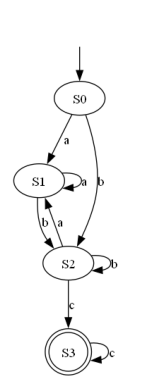

<Figure size 1500x1500 with 0 Axes>

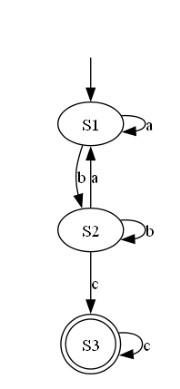

<Figure size 1500x1500 with 0 Axes>

done


In [18]:
# load the json file test1.json
with open('test7.json') as f:
    test1 = json.load(f)
    
    test6 = "((00)|1)*1(0|1)"

Requirement2(test1)